<a href="https://colab.research.google.com/github/AntonyZhuang/Capstone_GeneticAlgorithm/blob/main/GA_knapsack_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import random
import numpy as np

class GeneticAlgorithm:
    def __init__(self, population_size, chromosome_length, crossover_rate, mutation_rate,
                 max_generations, tournament_size, fitness_fn, penalty_mode=False,
                 penalty_factor=5, early_stop_generations=30):
        self.population_size = population_size
        self.chromosome_length = chromosome_length
        self.crossover_rate = crossover_rate
        self.base_mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.tournament_size = tournament_size
        self.fitness_fn = fitness_fn
        self.penalty_mode = penalty_mode
        self.penalty_factor = penalty_factor
        self.early_stop_generations = early_stop_generations
        self.diversity_threshold = 0.1
        self.stagnation_counter = 0
        
    def initialize_population(self):
        population = []
        for i in range(self.population_size):
            if i < self.population_size * 0.3:
                # 30% random initialization
                individual = [random.randint(0, 1) for _ in range(self.chromosome_length)]
            else:
                # 70% biased initialization (prefer lighter items initially)
                individual = [1 if random.random() < 0.3 else 0 for _ in range(self.chromosome_length)]
            population.append(individual)
        return population

    def evaluate_population(self, population):
        fitnesses = [self.fitness_fn(ind, penalty_mode=self.penalty_mode,
                                     penalty_factor=self.penalty_factor) for ind in population]
        return fitnesses

    def calculate_diversity(self, population):
        # Calculate hamming distance based diversity
        diversity = 0
        count = 0
        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                diversity += sum(a != b for a, b in zip(population[i], population[j]))
                count += 1
        return diversity / (count * self.chromosome_length) if count > 0 else 0

    def tournament_selection(self, population, fitnesses):
        tournament_indices = random.sample(range(len(population)), self.tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
        return population[winner_idx]
    
    def roulette_wheel_selection(self, population, fitnesses):
        # Normalize fitnesses to avoid negative values
        min_fitness = min(fitnesses)
        adjusted_fitnesses = [f - min_fitness + 1 for f in fitnesses]
        total = sum(adjusted_fitnesses)
        
        if total == 0:
            return random.choice(population)
        
        r = random.uniform(0, total)
        cumsum = 0
        for i, fitness in enumerate(adjusted_fitnesses):
            cumsum += fitness
            if cumsum >= r:
                return population[i]
        return population[-1]

    def uniform_crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            child1, child2 = [], []
            for i in range(self.chromosome_length):
                if random.random() < 0.5:
                    child1.append(parent1[i])
                    child2.append(parent2[i])
                else:
                    child1.append(parent2[i])
                    child2.append(parent1[i])
            return child1, child2
        return parent1[:], parent2[:]

    def multi_point_crossover(self, parent1, parent2, num_points=3):
        if random.random() < self.crossover_rate:
            points = sorted(random.sample(range(1, self.chromosome_length), min(num_points, self.chromosome_length - 1)))
            points = [0] + points + [self.chromosome_length]
            
            child1, child2 = [], []
            for i in range(len(points) - 1):
                if i % 2 == 0:
                    child1.extend(parent1[points[i]:points[i+1]])
                    child2.extend(parent2[points[i]:points[i+1]])
                else:
                    child1.extend(parent2[points[i]:points[i+1]])
                    child2.extend(parent1[points[i]:points[i+1]])
            return child1, child2
        return parent1[:], parent2[:]

    def adaptive_mutate(self, individual, mutation_rate, generation, fitness, avg_fitness):
        # Increase mutation for below-average individuals
        if fitness < avg_fitness:
            mutation_rate *= 1.5
        
        # Progressive mutation reduction
        mutation_rate *= (1 - generation / self.max_generations * 0.5)
        
        for i in range(self.chromosome_length):
            if random.random() < mutation_rate:
                individual[i] = 1 - individual[i]
        return individual

    def local_search(self, individual):
        # Hill climbing local search
        current_fitness = self.fitness_fn(individual, self.penalty_mode, self.penalty_factor)
        improved = individual[:]
        
        for _ in range(5):  # Limited iterations
            i = random.randint(0, self.chromosome_length - 1)
            improved[i] = 1 - improved[i]
            new_fitness = self.fitness_fn(improved, self.penalty_mode, self.penalty_factor)
            
            if new_fitness > current_fitness:
                current_fitness = new_fitness
                individual = improved[:]
            else:
                improved[i] = 1 - improved[i]  # Revert
                
        return individual

    def run(self):
        population = self.initialize_population()
        fitnesses = self.evaluate_population(population)

        best_solution = population[fitnesses.index(max(fitnesses))]
        best_fitness = max(fitnesses)
        best_generation = 0

        no_improvement = 0
        mutation_rate = self.base_mutation_rate
        history = []
        
        # Track diversity
        prev_best = best_fitness

        for generation in range(self.max_generations):
            new_population = []
            
            # Calculate diversity
            diversity = self.calculate_diversity(population)
            
            # Adaptive elitism based on diversity
            elite_size = 4 if diversity > self.diversity_threshold else 2
            sorted_indices = sorted(range(len(fitnesses)), key=lambda i: fitnesses[i], reverse=True)
            for i in range(elite_size):
                new_population.append(population[sorted_indices[i]][:])
            
            # Apply local search to best individual occasionally
            if generation % 10 == 0 and generation > 0:
                best_idx = sorted_indices[0]
                population[best_idx] = self.local_search(population[best_idx])
                fitnesses[best_idx] = self.fitness_fn(population[best_idx], self.penalty_mode, self.penalty_factor)

            # Generate new individuals with mixed selection strategies
            while len(new_population) < self.population_size:
                # Alternate between selection methods
                if random.random() < 0.7:
                    parent1 = self.tournament_selection(population, fitnesses)
                    parent2 = self.tournament_selection(population, fitnesses)
                else:
                    parent1 = self.roulette_wheel_selection(population, fitnesses)
                    parent2 = self.roulette_wheel_selection(population, fitnesses)
                
                # Use different crossover methods
                if random.random() < 0.6:
                    child1, child2 = self.multi_point_crossover(parent1, parent2)
                else:
                    child1, child2 = self.uniform_crossover(parent1, parent2)
                
                # Adaptive mutation
                avg_fitness = sum(fitnesses) / len(fitnesses)
                child1_fitness = self.fitness_fn(child1, self.penalty_mode, self.penalty_factor)
                child2_fitness = self.fitness_fn(child2, self.penalty_mode, self.penalty_factor)
                
                child1 = self.adaptive_mutate(child1, mutation_rate, generation, child1_fitness, avg_fitness)
                child2 = self.adaptive_mutate(child2, mutation_rate, generation, child2_fitness, avg_fitness)
                
                new_population.extend([child1, child2])
            
            # Diversity injection if population converges too much
            if diversity < self.diversity_threshold and generation % 20 == 0:
                # Replace 10% worst individuals with random ones
                num_inject = int(0.1 * self.population_size)
                for i in range(num_inject):
                    idx = sorted_indices[-(i+1)]
                    new_population[idx] = [random.randint(0, 1) for _ in range(self.chromosome_length)]

            population = new_population[:self.population_size]
            fitnesses = self.evaluate_population(population)

            gen_best = max(fitnesses)
            gen_avg = sum(fitnesses) / len(fitnesses)
            gen_worst = min(fitnesses)
            history.append((generation + 1, gen_best, gen_avg))

            # Track improvement
            if gen_best > best_fitness:
                best_fitness = gen_best
                best_solution = population[fitnesses.index(gen_best)]
                best_generation = generation + 1
                no_improvement = 0
                mutation_rate = self.base_mutation_rate * 0.8  # Reduce mutation on improvement
            else:
                no_improvement += 1
                # More aggressive mutation increase
                if no_improvement > 5:
                    mutation_rate = min(0.15, mutation_rate * 1.1)

            if generation % 10 == 0:
                print(f"Gen {generation+1}: Best = {gen_best} | Avg = {gen_avg:.2f} | "
                      f"Worst = {gen_worst} | Diversity = {diversity:.3f} | Mutation = {mutation_rate:.3f}")

            # Advanced early stopping with restart
            if no_improvement >= self.early_stop_generations:
                if self.stagnation_counter < 2:  # Allow 2 restarts
                    print(f"\nRestarting population at generation {generation+1}")
                    # Keep top 20% and regenerate rest
                    keep_size = int(0.2 * self.population_size)
                    new_pop = [population[sorted_indices[i]][:] for i in range(keep_size)]
                    new_pop.extend([[random.randint(0, 1) for _ in range(self.chromosome_length)]
                                   for _ in range(self.population_size - keep_size)])
                    population = new_pop
                    fitnesses = self.evaluate_population(population)
                    no_improvement = 0
                    self.stagnation_counter += 1
                    mutation_rate = self.base_mutation_rate * 1.5
                else:
                    print(f"\nEarly stopping at generation {generation+1} (no improvement in {self.early_stop_generations} gens)")
                    break

        print(f"\nBest solution found at generation {best_generation}")
        return best_solution, best_fitness, history

In [9]:
import random

# Fixed random seed for reproducibility
SEED = 42
random.seed(SEED)

# Problem constants
CHROMOSOME_LENGTH = 128

# Generate random values and weights
VALUES = [random.randint(10, 100) for _ in range(CHROMOSOME_LENGTH)]
WEIGHTS = [random.randint(5, 50) for _ in range(CHROMOSOME_LENGTH)]

# Hardcoded capacity = 40% of total weight
CAPACITY = int(sum(WEIGHTS) * 0.4)

def knapsack_fitness(individual, penalty_mode=False, penalty_factor=5):
    total_value = 0
    total_weight = 0
    for bit, value, weight in zip(individual, VALUES, WEIGHTS):
        if bit == 1:
            total_value += value
            total_weight += weight
    if not penalty_mode:
        return total_value if total_weight <= CAPACITY else 0
    else:
        # Penalize overweight instead of discarding
        penalty = penalty_factor * max(0, total_weight - CAPACITY)
        return total_value - penalty


In [10]:
# Run optimized GA with better parameters
ga = GeneticAlgorithm(
        population_size=150,         # Increased population for better exploration
        chromosome_length=CHROMOSOME_LENGTH,
        crossover_rate=0.85,         # Higher crossover rate
        mutation_rate=0.008,         # Lower initial mutation
        max_generations=300,         # More generations allowed
        tournament_size=5,           # Larger tournament for better selection pressure
        fitness_fn=knapsack_fitness,
        penalty_mode=True,
        penalty_factor=3,            # Reduced penalty for better exploration
        early_stop_generations=50    # Earlier restart trigger
)

best_solution, best_fitness, history = ga.run()

print("\nFinal Best Solution:")
print("Best Fitness (Value):", best_fitness)

# Calculate actual weight
total_weight = sum(w for bit, w in zip(best_solution, WEIGHTS) if bit == 1)
print(f"Total Weight: {total_weight} / {CAPACITY} (Capacity)")
print(f"Weight Utilization: {total_weight/CAPACITY*100:.1f}%")

# Compare with DP optimal
dp_optimal = knapsack_dp(VALUES, WEIGHTS, CAPACITY)
accuracy = (best_fitness / dp_optimal) * 100
print(f"\nOptimal Solution (DP): {dp_optimal}")
print(f"GA Accuracy: {accuracy:.2f}%")
print(f"Gap from Optimal: {dp_optimal - best_fitness}")

Gen 1: Best = 3355 | Avg = 2657.64 | Worst = 1493 | Diversity = 0.464 | Mutation = 0.006
Gen 11: Best = 4282 | Avg = 3969.40 | Worst = 3510 | Diversity = 0.290 | Mutation = 0.006
Gen 21: Best = 4553 | Avg = 4403.63 | Worst = 4129 | Diversity = 0.135 | Mutation = 0.006
Gen 31: Best = 4663 | Avg = 4523.61 | Worst = 4242 | Diversity = 0.087 | Mutation = 0.006
Gen 41: Best = 4698 | Avg = 4402.30 | Worst = 1752 | Diversity = 0.036 | Mutation = 0.006
Gen 51: Best = 4712 | Avg = 4637.15 | Worst = 4438 | Diversity = 0.034 | Mutation = 0.006
Gen 61: Best = 4720 | Avg = 4433.67 | Worst = 1848 | Diversity = 0.027 | Mutation = 0.007
Gen 71: Best = 4724 | Avg = 4648.91 | Worst = 4443 | Diversity = 0.029 | Mutation = 0.009
Gen 81: Best = 4729 | Avg = 4431.13 | Worst = 1825 | Diversity = 0.030 | Mutation = 0.006
Gen 91: Best = 4734 | Avg = 4671.21 | Worst = 4355 | Diversity = 0.028 | Mutation = 0.008
Gen 101: Best = 4736 | Avg = 4461.88 | Worst = 2092 | Diversity = 0.022 | Mutation = 0.007
Gen 111: B

In [11]:
def knapsack_dp(values, weights, capacity):
    n = len(values)
    dp = [0] * (capacity + 1)
    for i in range(n):
        w, v = weights[i], values[i]
        for c in range(capacity, w - 1, -1):
            dp[c] = max(dp[c], dp[c - w] + v)
    return dp[capacity]

best_value = knapsack_dp(VALUES, WEIGHTS, CAPACITY)
print("Optimal value (via DP):", best_value)

Optimal value (via DP): 4739


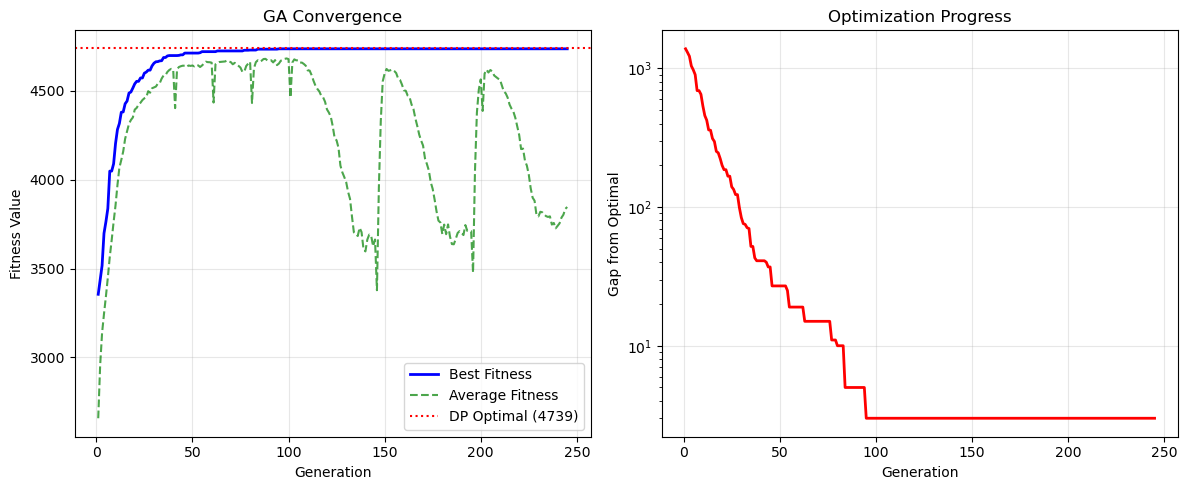


Performance Summary:
- Final accuracy: 99.94%
- Convergence generation: 245
- Best fitness achieved: 4736
- Average fitness (final gen): 3845.97


In [12]:
# Visualization of GA performance
import matplotlib.pyplot as plt

# Extract history data
generations = [h[0] for h in history]
best_fitnesses = [h[1] for h in history]
avg_fitnesses = [h[2] for h in history]

plt.figure(figsize=(12, 5))

# Plot 1: Fitness over generations
plt.subplot(1, 2, 1)
plt.plot(generations, best_fitnesses, 'b-', label='Best Fitness', linewidth=2)
plt.plot(generations, avg_fitnesses, 'g--', label='Average Fitness', alpha=0.7)
plt.axhline(y=dp_optimal, color='r', linestyle=':', label=f'DP Optimal ({dp_optimal})')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.title('GA Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Gap from optimal
plt.subplot(1, 2, 2)
gaps = [dp_optimal - bf for bf in best_fitnesses]
plt.plot(generations, gaps, 'r-', linewidth=2)
plt.xlabel('Generation')
plt.ylabel('Gap from Optimal')
plt.title('Optimization Progress')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"\nPerformance Summary:")
print(f"- Final accuracy: {accuracy:.2f}%")
print(f"- Convergence generation: {len(history)}")
print(f"- Best fitness achieved: {best_fitness}")
print(f"- Average fitness (final gen): {avg_fitnesses[-1]:.2f}")